<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4"
     alt="SAR2Cube logo"
     style="float: right; max-width: 200px" />
## SAR2Cube and openEO - Computing SAR Interferometric Coherence on-the-fly with a boxcar filter
Author michele.claus@eurac.edu

Date: 2023/01/09

Updated: 2023/05/15

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## Import all the libraries and utilities functions
The ones included in the eo_utils.py file are needed for the ipyleaflet interactive map

Please check to have the latest `openeo` library. Please check here for the latest available version: https://pypi.org/project/openeo/

In [14]:
import os
import openeo
import xarray as xr
import matplotlib.pyplot as plt
try:
    from eo_utils import *
except Exception as e:
    print(e)

### Connect and login

In [15]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


## SAR2Cube available data collections
### Doñana Datacubes:
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA
SAR2Cube_SInCohMap_S1_L0_154_DSC_DONYANA
```
Sentinel-2:
```
SInCohMap_S2_L1C_T29SQB
```
### South Tyrol Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL
SAR2Cube_SInCohMap_S1_L0_168_DSC_SOUTH_TYROL
```
Sentinel-2:
```
S2_L1C_T32TPS
```
### Finland Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI1
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI2
```

## Interferometric Coherence


Firstly download a tiny subset of the datacube for the whole timeseries.

With the downloaded netCDF we can extract the available dates and compute the master-slave pairs for the given temporal baseline.

**Please note: this step is not necessary since sample netCDFs with the vailable dates are already provided in the GitHub repo in the aux_data folder.**

The available netCDFs containing the dates for the SInCohMap Sentinel-1 datacubes are:
```
./aux_data/Donyana_ASC_147_dates.nc
./aux_data/Donyana_DSC_154_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/South_Tyrol_DSC_168_dates.nc
./aux_data/South_Tyrol_ASC_117_dates.nc
```

In [16]:
# conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
# spatial_extent  = {'west':-6.094129 ,'east':-6.091833 ,'south':37.115613 ,'north':37.117239}
# collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'
# # Not specifying the temporal extent will load the whole timeseries
# bands = ['grid_lon','grid_lat']
# S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

In [17]:
# %%time
# S1_slant_range.download('./aux_data/Donyana_ASC_147_dates.nc')

## AOI
We usa a sample AOI over Doñana, Spain

In [18]:
spatial_extent = {"west": -6.31,"east": -5.87,"south": 37.05,"north": 37.19}

Compute the master-slave pairs for the given temporal baseline.

Read the retrieved netCDF containing the timestamps:

In [19]:
dates_netcdf = xr.open_dataarray("./aux_data/Donyana_ASC_147_dates.nc")
print(dates_netcdf.time.values)

['2017-01-02T23:59:59.000000000' '2017-01-08T23:59:59.000000000'
 '2017-01-14T23:59:59.000000000' '2017-01-20T23:59:59.000000000'
 '2017-01-26T23:59:59.000000000' '2017-02-01T23:59:59.000000000'
 '2017-02-07T23:59:59.000000000' '2017-02-13T23:59:59.000000000'
 '2017-02-19T23:59:59.000000000' '2017-02-25T23:59:59.000000000'
 '2017-03-03T23:59:59.000000000' '2017-03-09T23:59:59.000000000'
 '2017-03-15T23:59:59.000000000' '2017-03-21T23:59:59.000000000'
 '2017-04-02T23:59:59.000000000' '2017-04-08T23:59:59.000000000'
 '2017-04-14T23:59:59.000000000' '2017-04-20T23:59:59.000000000'
 '2017-04-26T23:59:59.000000000' '2017-05-02T23:59:59.000000000'
 '2017-05-08T23:59:59.000000000' '2017-05-14T23:59:59.000000000'
 '2017-05-20T23:59:59.000000000' '2017-05-26T23:59:59.000000000'
 '2017-06-01T23:59:59.000000000' '2017-06-07T23:59:59.000000000'
 '2017-06-13T23:59:59.000000000' '2017-06-19T23:59:59.000000000'
 '2017-06-25T23:59:59.000000000' '2017-07-01T23:59:59.000000000'
 '2017-07-07T23:59:59.000

Coherence temporal baseline

In [20]:
timedelta = 6

We want to compute the coherence for a pair of dates in January 2018. (Please try a small temporal extent firstly)

In [21]:
timesteps = dates_netcdf["time"].loc[dict(time=slice("2018-01-27","2018-02-03"))].values
print("First date available: ",timesteps[0])
print("Last date available:  ",timesteps[-1])

First date available:  2018-01-27T23:59:59.000000000
Last date available:   2018-02-02T23:59:59.000000000


We loop through the timesteps and check where we have 6 or 12 or ... days pairs of dates

In [22]:
dates_pair = []
for i,t in enumerate(timesteps[:-1]):
    for t2 in timesteps[i+1:]:
        if(np.timedelta64(t2 - t, "D")) == np.timedelta64(timedelta,"D"):
            dates_pair.append([t,t2])
print("First date pair: ",dates_pair[0])
print("Last date pair:  ",dates_pair[-1])

First date pair:  [numpy.datetime64('2018-01-27T23:59:59.000000000'), numpy.datetime64('2018-02-02T23:59:59.000000000')]
Last date pair:   [numpy.datetime64('2018-01-27T23:59:59.000000000'), numpy.datetime64('2018-02-02T23:59:59.000000000')]


We define new temporal labels containing the master and slave dates:

In [23]:
mst_slv_temporal_labels = [ str(i[0])[:10] + "_" + str(i[1])[:10] for i in dates_pair]
mst_slv_temporal_labels.reverse()
print("The output will have a temporal label named like this: ",mst_slv_temporal_labels[0])

The output will have a temporal label named like this:  2018-01-27_2018-02-02


We now got the master-slave date pairs which will be used to compute the coherence.

Now we define the utility functions for computing the complex coherence and then its amplitude

In [33]:
from openeo.processes import ProcessBuilder, array_element

def compute_real_part_numerator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VV_mst")
    q_mst = array_element(x,label="q_VV_mst")
    i_slv = array_element(x,label="i_VV_slv")
    q_slv = array_element(x,label="q_VV_slv")
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VV_mst")
    q_mst = array_element(x,label="q_VV_mst")
    i_slv = array_element(x,label="i_VV_slv")
    q_slv = array_element(x,label="q_VV_slv")
    return (q_mst*i_slv - i_mst*q_slv)

def compute_real_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VH_mst")
    q_mst = array_element(x,label="q_VH_mst")
    i_slv = array_element(x,label="i_VH_slv")
    q_slv = array_element(x,label="q_VH_slv")
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VH_mst")
    q_mst = array_element(x,label="q_VH_mst")
    i_slv = array_element(x,label="i_VH_slv")
    q_slv = array_element(x,label="q_VH_slv")
    return (q_mst*i_slv - i_mst*q_slv)

def compute_mst_denominator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VV_mst")
    q_mst = array_element(x,label="q_VV_mst")
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VV(x:ProcessBuilder):
    i_slv = array_element(x,label="i_VV_slv")
    q_slv = array_element(x,label="q_VV_slv")
    return (i_slv**2+q_slv**2)

def compute_mst_denominator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VH_mst")
    q_mst = array_element(x,label="q_VH_mst")
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VH(x:ProcessBuilder):
    i_slv = array_element(x,label="i_VH_slv")
    q_slv = array_element(x,label="q_VH_slv")
    return (i_slv**2+q_slv**2)

def compute_coherence_amplitude_VV(x:ProcessBuilder):
    q_num_VV = array_element(x,label="q_num_VV")
    i_num_VV = array_element(x,label="i_num_VV")
    mst_den = array_element(x,label="mst_den")
    slv_den = array_element(x,label="slv_den")
    
    coh_i = i_num_VV / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VV / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

def compute_coherence_amplitude_VH(x:ProcessBuilder):
    q_num_VH = array_element(x,label="q_num_VH")
    i_num_VH = array_element(x,label="i_num_VH")
    mst_den = array_element(x,label="mst_den")
    slv_den = array_element(x,label="slv_den")
    
    coh_i = i_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

Coherence parameters:

In [34]:
# Boxcar filter
range_dim   = 19
azimuth_dim = 4

# Geocoding
resolution = 10 # can be 10, 20 or 60 meters, it will be aligned with the Sentinel-2 grid
crs = 32629

# Datacube
collection = "SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA"

In [35]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
bands = ["grid_lon","grid_lat","i_VH","q_VH"]
S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

# We use a loop over the dates we want to request and a combination of filter_temporal + merge_cubes to get only the dates we want:
for i,date_pair in enumerate(dates_pair):
    # The requested date until the day after, since openEO excludes the end date
    mst_date = date_pair[0]
    slv_date = date_pair[1]
    mst_temporal_extent = [str(mst_date),str(mst_date + np.timedelta64(1, "D"))]
    slv_temporal_extent = [str(slv_date),str(slv_date + np.timedelta64(1, "D"))]

    if i == 0:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent)
    else:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent).merge_cubes(S1_slant_range_mst_bands)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent).merge_cubes(S1_slant_range_slv_bands)

Authenticated using refresh token.


In [36]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.filter_bands(["i_VH","q_VH"])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.filter_bands(["i_VH","q_VH"])

We rename the temporal labels to facilitate the next steps of the coherence computation:

In [37]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.rename_labels(dimension="DATE",
                                                                  target=mst_slv_temporal_labels)
S1_slant_range_slv_bands = S1_slant_range_slv_bands.rename_labels(dimension="DATE",
                                                                  target=mst_slv_temporal_labels)

We rename the bands according to the master/slave members

In [38]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.rename_labels(dimension="bands",
                                                                  source=["i_VH","q_VH"],
                                                                  target=["i_VH_mst","q_VH_mst"])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.rename_labels(dimension="bands",
                                                                  source=["i_VH","q_VH"],
                                                                  target=["i_VH_slv","q_VH_slv"])

Merge the two datacubes into a single one

In [39]:
S1_slant_range_mst_slv_bands = S1_slant_range_mst_bands.merge_cubes(S1_slant_range_slv_bands)

Compute the coherence numerator for VH

In [40]:
i_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",
                                                               reducer=compute_real_part_numerator_VH)
q_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",
                                                               reducer=compute_imag_part_numerator_VH)

Compute the coherence denominator

In [41]:
mst_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",
                                                                   reducer=compute_mst_denominator_VH)
slv_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",
                                                                   reducer=compute_slv_denominator_VH)

Merge all the bands

In [42]:
i_numerator_VH_with_dim = i_numerator_VH.add_dimension(type="bands",name="bands",label="i_num_VH")
q_numerator_VH_with_dim = q_numerator_VH.add_dimension(type="bands",name="bands",label="q_num_VH")
mst_denominator_VH_with_dim = mst_denominator_VH.add_dimension(type="bands",name="bands",label="mst_den")
slv_denominator_VH_with_dim = slv_denominator_VH.add_dimension(type="bands",name="bands",label="slv_den")

coh_numerator_denominator_VH = i_numerator_VH_with_dim.merge_cubes(q_numerator_VH_with_dim).merge_cubes(mst_denominator_VH_with_dim).merge_cubes(slv_denominator_VH_with_dim)

Apply boxcar filter using the `apply_kernel` openEO process. More info here: https://processes.openeo.org/#apply_kernel

In [46]:
kernel = np.ones((range_dim,azimuth_dim))
coh_numerator_denominator_VH_boxcar = coh_numerator_denominator_VH.apply_kernel(kernel=kernel,
                                                                                factor=1/(range_dim*azimuth_dim),
                                                                                border="reflect")

Compute the coherence amplitude

In [47]:
coh_VH = coh_numerator_denominator_VH_boxcar.reduce_dimension(dimension="bands",
                                                              reducer=compute_coherence_amplitude_VH)
coh_amplitude = coh_VH.add_dimension(name="bands",
                              label="coh_vh_amp")

Apply geocoding. We choose 10m resolution for the pixel size and the local UTM zone as projection.

We can choose only from 10, 20 or 60m for resolution, for being able to align the data with Sentinel-2 grid.

This process is not yet an official openEO process and therefore the syntax to apply it is not streamlined as with the other processes.

In [48]:
lat_lon_grids = S1_slant_range.filter_bands(["grid_lon","grid_lat"]).reduce_dimension(dimension="DATE",
                                                                                      reducer="mean")
coh_amplitude = coh_amplitude.merge_cubes(lat_lon_grids)

args_geocoding = {"resolution":resolution,"crs":crs}
coh_amplitude_geocoded = coh_amplitude.process("geocode",args_geocoding, data=coh_amplitude).reduce_dimension(dimension="DATE",reducer="mean")

coh_amplitude_geocoded_tif = coh_amplitude_geocoded.save_result(format="GTIFF")

Create a batch job and start it

In [32]:
job = conn.create_job(coh_amplitude_geocoded_tif,title="SAR2CUBE_coherence_Donyana_ASC_boxcar_10m")
job_id = job.job_id
print("Batch job created with id: ",job_id)
job.start_job()

Batch job created with id:  fa001dc7-c8fc-4690-8f68-cbc30a10c7c6


Visualize the job status

In [38]:
job = conn.job(job_id)
job

<BatchJob job_id='fa001dc7-c8fc-4690-8f68-cbc30a10c7c6'>

Create the output folder to store the results:

In [25]:
import os
result_dir_name = "coherence_results_ML"
if not os.path.exists(result_dir_name):
    os.mkdir(result_dir_name)

Once the job is marked as finished, you can download the result.

Either via the download link provided in the following visualization:

In [40]:
result = job.get_results()
result

<JobResults for job 'fa001dc7-c8fc-4690-8f68-cbc30a10c7c6'>

Or via python code specifying the target location:

In [41]:
result.download_files(result_dir_name + '/')

[PosixPath('coherence_results_ML/result.tiff'),
 PosixPath('coherence_results_ML/process.json'),
 PosixPath('coherence_results_ML/job-results.json')]

Loading the geoTiff using rioxarray

In [26]:
result = rioxarray.open_rasterio(result_dir_name + "/result.tiff")
result

<xarray.DataArray (band: 1, y: 1674, x: 3959)>
[6627366 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.388e+05 7.388e+05 ... 7.783e+05 7.784e+05
  * y            (y) float64 4.121e+06 4.121e+06 ... 4.104e+06 4.104e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        0.99478250741959
    STATISTICS_MEAN:           0.41527537366854
    STATISTICS_MINIMUM:        0.00022328218619805
    STATISTICS_STDDEV:         0.1771252973051
    STATISTICS_VALID_PERCENT:  91.75
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 coh_vh_amp

Visualize the result with matplotlib

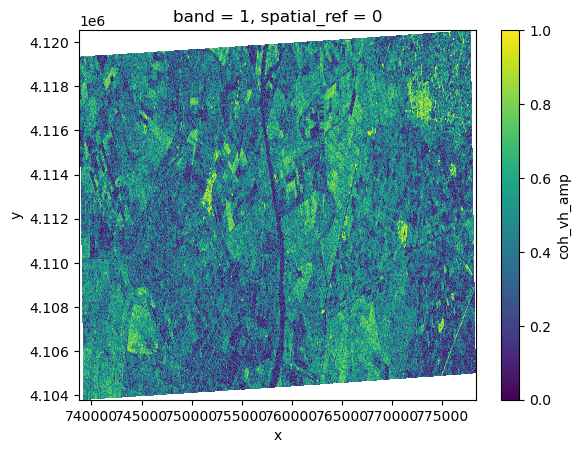

In [27]:
result[0].plot.imshow(vmin=0,vmax=1)

Visualize the result with ipyleaflet interactively

In [34]:
center = [37.1, -6]
zoom = 12

eoMap = openeoMap(center,zoom)
addLayer(eoMap,"./coherence_results_ML/result.tiff","VH_COH_10m",clip=[0,1])
eoMap.map

Url()

Map(center=[37.1, -6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…